In [2]:
from sklearn.svm import SVC # Support Vector Classifier for anomaly detection
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif

              precision    recall  f1-score   support

           0       0.70      0.50      0.58      2912
           1       0.22      0.41      0.29      1035

    accuracy                           0.47      3947
   macro avg       0.46      0.45      0.44      3947
weighted avg       0.58      0.47      0.51      3947



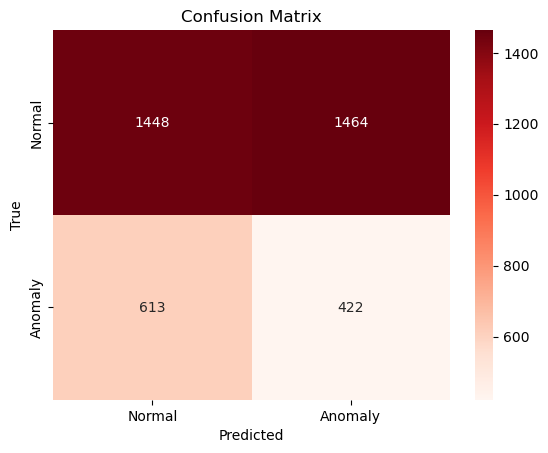

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

def hybrid_anomaly_detection_svm_if():
    
    data = pd.read_csv('energydata.csv')
    
    data = data.drop('date', axis=1)
    
    X = data.drop('Windspeed', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['Windspeed']
    
    #convert all the values in the columns into numeric
    for column in data.columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')

    data.dropna(axis=0, inplace=True)
    
#     #Scatter plot
#     sns.pairplot(data, kind='scatter')
#     plt.title('Scatter Plot')
#     plt.show()
    
    
    y = np.where(y_cont > 5, 1, 0)  # Define `threshold` based on the dataset
    
        
    # Select top k features; you might adjust k based on your dataset
    selector = SelectKBest(f_classif, k=10)
    X_selected = selector.fit_transform(X, y)
    
    
    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=5)
    
    # Phase 1: SVM for initial anomaly detection
    svm_model = OneClassSVM(nu=0.1, kernel='rbf', gamma='auto').fit(X_train)
    svm_predictions = svm_model.predict(X_train)
    # Prepare SVM predictions for training Isolation Forest
    svm_predictions_for_if = (svm_predictions == -1).astype(int)  # Convert -1 to 0 (anomaly) and 1 to 1 (normal)

    # Enhance the original training data with SVM predictions
    X_train_enhanced = np.hstack((X_train, svm_predictions_for_if.reshape(-1, 1)))
    X_test_enhanced = np.hstack((X_test, svm_model.predict(X_test).reshape(-1, 1)))
    
    # Phase 2: Train Isolation Forest with the enhanced dataset
    iso_forest = IsolationForest(contamination='auto', n_estimators=100, random_state=5).fit(X_train_enhanced)
    iso_forest_predictions = iso_forest.predict(X_test_enhanced)
    iso_forest_predictions_binary = (iso_forest_predictions == 1).astype(int)  # Convert -1 to 0 and 1 to 1
    
    print(classification_report(y_test, iso_forest_predictions_binary))
    
    # Evaluation
    precision = precision_score(y_test, iso_forest_predictions_binary)
    recall = recall_score(y_test, iso_forest_predictions_binary)
    f1 = f1_score(y_test, iso_forest_predictions_binary)
    #print(f"Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
    
    
        # Confusion Matrix Visualization
    conf_matrix = confusion_matrix(y_test, iso_forest_predictions_binary)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    
        # Evaluate the SVM model
    precision = precision_score(y_test, iso_forest_predictions_binary, average='micro')
    recall = recall_score(y_test, iso_forest_predictions_binary, average='micro')
    f1 = f1_score(y_test, iso_forest_predictions_binary, average='micro')
    conf_matrix = confusion_matrix(y_test, iso_forest_predictions_binary)
    

hybrid_anomaly_detection_svm_if()
